In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from cycler import cycler
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
sns.set_style()

In [ ]:
import matplotlib.pylab as pylab
params = {
    'font.size': 12,
    'legend.fontsize':'large',
    'figure.titlesize':'large',
    'axes.grid':False,
    'axes.labelsize':'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    #'figure.figsize': (5, 6)
    }
pylab.rcParams.update(params)

In [ ]:
def plot_data_by_cell(df):
    plt.figure(figsize=(10, 6))
    for group_index, group_data in df.groupby('Cell'):
        plt.plot(group_data['T (h.p.i.)'], group_data['eGFP Intensity'], label=f'Cell {group_index}')

    plt.xlabel('T (h.p.i.)')
    plt.ylabel('eGFP Intensity')
    #plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def create_icons(df): # Create plain icons
    if 'Cell' not in df.columns or 'T (h.p.i.)' not in df.columns or 'eGFP Intensity' not in df.columns:
            raise ValueError("DataFrame must contain 'Cell', 'T (h.p.i.)', and 'eGFP Intensity' columns")
    files_list = []
    x_scale = max(df.groupby('Cell').apply(lambda x: x['T (h.p.i.)'].max() - x['T (h.p.i.)'].min()))
    y_scale = max(df.groupby('Cell').apply(lambda x: x['eGFP Intensity'].max() - x['eGFP Intensity'].min()))
    cells = [group for _, group in df.groupby('Cell', as_index=False)]

    for i, cell_data in enumerate(cells):
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.lineplot(data=cell_data, x='T (h.p.i.)', y='eGFP Intensity', color='none', ax=ax, linestyle='none', linewidth=2)
        ax.fill_between(cell_data['T (h.p.i.)'], cell_data['eGFP Intensity'], alpha=0.7, color='mediumpurple')

        ax.set_xlim([cell_data['T (h.p.i.)'].min(), cell_data['T (h.p.i.)'].min() + x_scale])
        ax.set_ylim([cell_data['eGFP Intensity'].min(), cell_data['eGFP Intensity'].min() + y_scale])
        ax.axis('off')
        fig.patch.set_visible(False)

        file_name = f'Cell_{i+1}.png'
        fig.savefig(file_name, dpi=150, transparent=True)
        plt.close(fig)

        files_list.append(file_name)

    return files_list

In [ ]:
def scatter_with_icons(df, files_list, icon_zoom, figsize):
    # get images for the scatter plot
    def getImage(file_path):
        try:
            image = mpimg.imread(file_path)
            return OffsetImage(image, zoom=icon_zoom)
        except FileNotFoundError:
            print(f"File {file_path} not found.")
            return OffsetImage(np.zeros((1, 1, 3)), zoom=icon_zoom)  # Return an empty image if file not found

    # Extract peak intensities and corresponding times
    plot_array = []
    cell_data = [group for _, group in df.groupby('Cell', as_index=False)]
    for cell_n in cell_data:
        cell_n = cell_n.to_numpy()
        # Find the index of the maximum intensity
        max_index = np.argmax(cell_n[:, 2])
        plot_array.append([cell_n[max_index, 0], cell_n[max_index, 1], cell_n[max_index, 2]])
    plot_array = np.array(plot_array)  # Array format: [time, cell#, intensity]

    # Create scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(plot_array[:, 0], plot_array[:, 2], alpha=0.01)

    # Add image icons to the scatter plot
    for x, y, path in zip(plot_array[:, 0], plot_array[:, 2], files_list):
        image_box = AnnotationBbox(getImage(path), (x, y), frameon=False, pad=0.0)
        ax.add_artist(image_box)

    ax.set_xlabel('Time of Maximum Intensity [hours]')
    ax.set_ylabel('Maximum eGFP Intensity [a.u.]')
    plt.tight_layout()
    plt.show()

In [ ]:
def extract_features(file_name, sheet_name):
    df = pd.read_excel(file_name, sheet_name)
    cell = [y for _, y in df.groupby('Cell', as_index=False)]
    cell_number = np.arange(0,len(cell))
    features = []
    for i in cell_number:
        cell0 = cell.pop(0).to_numpy()
        idx_max = np.argmax(cell0[:,2])
        GFPmax = 0.85*cell0[idx_max,2]
        infection_time = time_feature(cell0[0,0],cell0[0,2],cell0[1,0],cell0[1,2],20)
        idx = np.argwhere(cell0[:idx_max,2]>=GFPmax)
        if len(idx)==0:
            idx = idx_max
        else:
            idx = idx.item(0)
        rise_time_pt = time_feature(cell0[idx-1,0],cell0[idx-1,2],cell0[idx,0],cell0[idx,2],GFPmax) # absolute time to reach GFPmax
        rise_time = rise_time_pt - infection_time # length of the rise phase
        lysis_time = time_feature(cell0[-2,0],cell0[-2,2],cell0[-1,0],cell0[-1,2],20)
        infection_duration = lysis_time-infection_time
        rise_rate = (GFPmax-20)/rise_time
        #area under the curve during infection duration
        area = np.trapz(cell0[:,2]) - (0.5*(infection_time-cell0[0,0])*(20-cell0[0,2]) + 0.5*(cell0[-1,0]-lysis_time)*(20-cell0[-1,2]))
        features.append([i+1, GFPmax, infection_time, rise_time, lysis_time, infection_duration, rise_rate, area])
    features_df = pd.DataFrame(features, columns=['Cell #',
                                                  'GFP max [a.u.]',
                                                  'Infection time [h.p.i]',
                                                  'Rise time [h]',
                                                  'Lysis time [h.p.i]',
                                                  'Infection duration [h]',
                                                  'Rise rate [a.u. /h]',
                                                  'Area [a.u. h]']).reset_index(drop=True)
    # print(f'Column names: {features_df.columns.values}')
    return features_df, features_df.columns.values


def time_feature(t1, int1, t2, int2, y):
    if t2 == t1:
        raise ValueError("Time values cannot be the same.")
    slope = (int2 - int1) / (t2 - t1)
    t = t1 + (y - int1) / slope
    return t

In [ ]:
def custom_scatterplot(df, features_df, x_var, y_var, files_list, icon_zoom, figsize):
    # get images for the scatter plot
    def getImage(file_path):
        try:
            image = mpimg.imread(file_path)
            return OffsetImage(image, zoom=icon_zoom)
        except FileNotFoundError:
            print(f"File {file_path} not found.")
            return OffsetImage(np.zeros((1, 1, 3)), zoom=icon_zoom)  # Return an empty image if file not found

    # Create scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(features_df[x_var], features_df[y_var], alpha=0.01)

    # Add image icons to the scatter plot
    for x, y, path in zip(features_df[x_var], features_df[y_var], files_list):
        image_box = AnnotationBbox(getImage(path), (x, y), frameon=False, pad=0.5)

        ax.add_artist(image_box)

    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    plt.tight_layout()
    plt.show()

In [ ]:
def spatial_scatter_with_icons(df, files_list, icon_zoom, figsize, xmin, xmax, ymin, ymax):
    def getImage(files_list):
            return OffsetImage(plt.imread(path, format="png"), zoom=icon_zoom)
    import matplotlib
    appended_results_3 = []
    cell = [y for _, y in df.groupby('Cell', as_index=False)]
    for n_cell, cell_n in enumerate(cell):
        cell_n = cell_n.to_numpy()
        r, c = np.unravel_index(np.argmax(cell_n, axis=None), cell_n.shape)
        appended_results_3.append([cell_n[r,0], cell_n[r,1], cell_n[r,2], cell_n[0,3], cell_n[0,4]])
    appended_results_3 = np.asarray(appended_results_3) #array format: [time, cell#, intensity, x, y]

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor('xkcd:grey')
    #ax.tripcolor(appended_results_3[:,3], appended_results_3[:,4], appended_results_3[:,0])
    ax.scatter(appended_results_3[:,3], appended_results_3[:,4], alpha=0.01)
    #ax.set_xlim(1100,1800), ax.set_ylim(12800,14000)
    ax.set_xlim(xmin, xmax), ax.set_ylim(ymin, ymax)
    tcf = ax.tricontourf(appended_results_3[:,3], appended_results_3[:,4], appended_results_3[:,0], cmap=matplotlib.cm.get_cmap('Blues_r'))
    fig.colorbar(tcf, label='Time of maximum intensity [hours]') #temporal colorbar
    for x, y, path in zip(appended_results_3[:,3], appended_results_3[:,4], files_list):
        ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
        ax.add_artist(ab)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.tight_layout()
    plt.show()

In [ ]:
def all_cells_single_plot(df):
    plot_all_cells = df.copy(deep=True) #create a copy for plotting
    plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'k'])*cycler('linestyle', ['-', '--', ':', '-.'])))
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks(np.arange(0, plot_all_cells.index[-1]+1, 5))
    ax.set_xticks(np.arange(0, plot_all_cells.index[-1]+1, 1), minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    plot_all_cells.set_index('T (h.p.i.)', inplace=True)
    plot_all_cells.groupby('Cell')['eGFP Intensity'].plot(x='T (h.p.i.)', y='eGFP Intensity', lw=3, legend=True, ax=ax)
    plt.legend(loc="lower left", ncol=12, bbox_to_anchor=(0, -0.5))
    plt.ylabel('eGFP Intensity')
    plt.title(f'{sheet_name}')
    #plt.locator_params(axis='x', integer=True, tight=True)
    plt.show()

In [ ]:
def all_cells_separate_plots(df):
    #import matplotlib.ticker as ticker
    cell = [y for _, y in df.groupby('Cell', as_index=False)]
    cell_number = np.arange(0,len(cell))
    for i in cell_number:
        fig, ax = plt.subplots()
        ax.set_xlabel('T (h.p.i.)')
        ax.set_ylabel('eGFP Intensity')
        cell[i].plot(x='T (h.p.i.)', y='eGFP Intensity', kind='scatter', ax=ax, figsize=(10,5), c='r', label = 'Cell '+str(i+1))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.legend(loc='center right', ncol=12, bbox_to_anchor=(1.3, 0.5))
        plt.show(fig)


In [ ]:
def all_cells_subplots(df):
    cell = [y for _, y in df.groupby('Cell', as_index=False)]
    total_cells = np.arange(len(cell))
    subplotsize = math.ceil(len(cell)/5)
    plt.suptitle(f'{sheet_name}', y=0.98)
    for i in total_cells:
        cell0 = cell.pop(0).to_numpy()
        plt.subplot(subplotsize,5,i+1)
        plt.plot(cell0[:,0],cell0[:,2], c='red', marker='o', linestyle='dashed')
        #----------------------------------------------------------
        # this block for identifying minor peaks in the subplots
        for j in range(1,len(cell0)-2):
            if cell0[j,2]<cell0[j-1,2] and cell0[j,2]<cell0[j+1,2]:
                plt.plot(cell0[j,0],cell0[j,2], 'bo')
        #----------------------------------------------------------
        plt.xlabel('T (h.p.i.)')
        plt.ylabel('eGFP Intensity')
        plt.title(f'Cell {i+1}')
        plt.tight_layout()
    plt.show()

<ipython-input-24-94219b56429e>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x_scale = max(df.groupby('Cell').apply(lambda x: x['T (h.p.i.)'].max() - x['T (h.p.i.)'].min()))
<ipython-input-24-94219b56429e>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_scale = max(df.groupby('Cell').apply(lambda x: x['eGFP Intensity'].max() - x['eGFP Intensity'].min()))


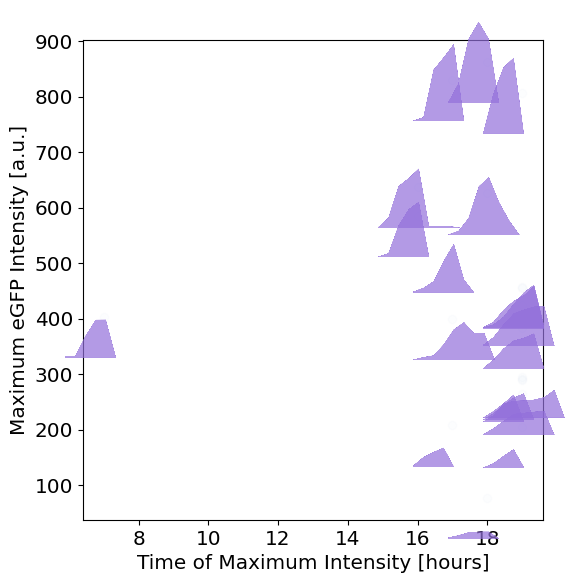

In [ ]:
file_name = 'experimental data.xlsx'
sheet_name = 'plaque 1'
df = pd.read_excel(file_name, sheet_name)
files_list = create_icons(df)
#spatial_scatter_with_icons(df, files_list, 0.1, (14,14), 0, 12800, 0, 9700)
scatter_with_icons(df, files_list, 0.1, (6,6))

{'Cell #': 0, 'GFP max [a.u.]': 1, 'Infection time [h.p.i]': 2, 'Rise time [h]': 3, 'Lysis time [h.p.i]': 4, 'Infection duration [h]': 5, 'Rise rate [a.u. /h]': 6, 'Area [a.u. h]': 7}


<ipython-input-24-94219b56429e>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x_scale = max(df.groupby('Cell').apply(lambda x: x['T (h.p.i.)'].max() - x['T (h.p.i.)'].min()))
<ipython-input-24-94219b56429e>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_scale = max(df.groupby('Cell').apply(lambda x: x['eGFP Intensity'].max() - x['eGFP Intensity'].min()))


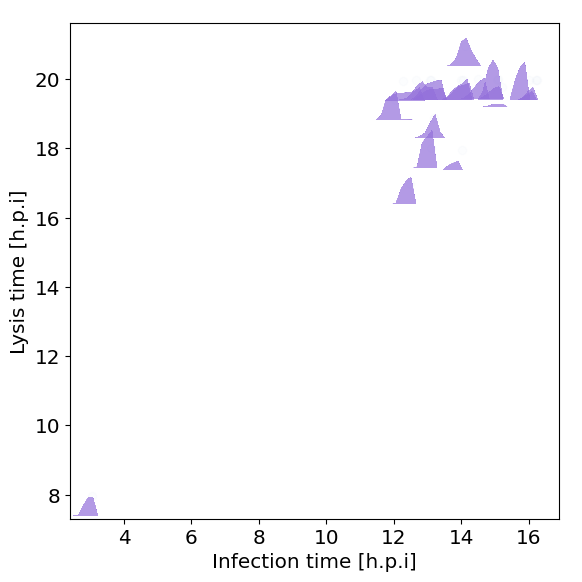

In [ ]:
file_name = 'experimental data.xlsx'
sheet_name = 'plaque 1'
features_df, col_names = extract_features(file_name, sheet_name)
col_index_map = {name: index for index, name in enumerate(col_names)}
print(col_index_map)
df = pd.read_excel(file_name, sheet_name)
files_list = create_icons(df)
custom_scatterplot(df, features_df, col_names[2], col_names[4], files_list, 0.05, (6,6))

In [ ]:
def create_icons_allPlaques(df):  # Create plain icons
    if 'Cell' not in df.columns or 'T (h.p.i.)' not in df.columns or 'eGFP Intensity' not in df.columns:
        raise ValueError("DataFrame must contain 'Cell', 'T (h.p.i.)', and 'eGFP Intensity' columns")

    # Define color ranges
    color_ranges = [
        (0, 20, 'black'),
        (20, 34, 'blue'),
        (34, 49, 'green'),
        (49, 73, 'red'),
        (73, 86, 'cyan'),
        (86, 94, 'magenta'),
        (94, 117, 'gray'),
        (117, 153, 'purple')
    ]

    # Helper function to get color based on cell number
    def get_color(cell_number):
        for start, end, color in color_ranges:
            if start <= cell_number < end:
                return color
        return 'black'  # Default color if no range matches

    files_list = []
    x_scale = max(df.groupby('Cell').apply(lambda x: x['T (h.p.i.)'].max() - x['T (h.p.i.)'].min()))
    y_scale = max(df.groupby('Cell').apply(lambda x: x['eGFP Intensity'].max() - x['eGFP Intensity'].min()))
    cells = [group for _, group in df.groupby('Cell', as_index=False)]

    for i, cell_data in enumerate(cells):
        cell_number = cell_data['Cell'].iloc[0]  # Assuming cell number is consistent within each group
        color = get_color(cell_number)

        fig, ax = plt.subplots(figsize=(5, 5))
        sns.lineplot(data=cell_data, x='T (h.p.i.)', y='eGFP Intensity', color='none', ax=ax, linestyle='none', linewidth=2)
        ax.fill_between(cell_data['T (h.p.i.)'], cell_data['eGFP Intensity'], alpha=0.7, color=color)

        ax.set_xlim([cell_data['T (h.p.i.)'].min(), cell_data['T (h.p.i.)'].min() + x_scale])
        ax.set_ylim([cell_data['eGFP Intensity'].min(), cell_data['eGFP Intensity'].min() + y_scale])
        ax.axis('off')
        fig.patch.set_visible(False)

        file_name = f'Cell_{i+1}.png'
        fig.savefig(file_name, dpi=150, transparent=True)
        plt.close(fig)

        files_list.append(file_name)

    return files_list


{'Cell #': 0, 'GFP max [a.u.]': 1, 'Infection time [h.p.i]': 2, 'Rise time [h]': 3, 'Lysis time [h.p.i]': 4, 'Infection duration [h]': 5, 'Rise rate [a.u. /h]': 6, 'Area [a.u. h]': 7}


<ipython-input-37-70e3f0f242dd>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x_scale = max(df.groupby('Cell').apply(lambda x: x['T (h.p.i.)'].max() - x['T (h.p.i.)'].min()))
<ipython-input-37-70e3f0f242dd>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_scale = max(df.groupby('Cell').apply(lambda x: x['eGFP Intensity'].max() - x['eGFP Intensity'].min()))


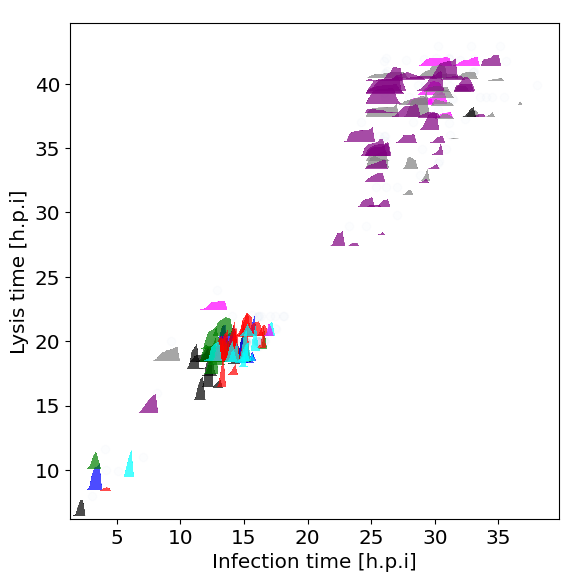

In [ ]:
file_name = 'experimental data.xlsx'
sheet_name = 'Copy of all plaques'
features_df, col_names = extract_features(file_name, sheet_name)
col_index_map = {name: index for index, name in enumerate(col_names)}
print(col_index_map)
df = pd.read_excel(file_name, sheet_name)
files_list = create_icons_allPlaques(df)
custom_scatterplot(df, features_df, col_names[2], col_names[4], files_list, 0.05, (6,6))

In [ ]:
file_name = 'experimental data.xlsx'
a1,_ = extract_features(file_name, 'plaque 1')
a2,_ = extract_features(file_name, 'plaque 2')
a3,_ = extract_features(file_name, 'plaque 3')
a4,_ = extract_features(file_name, 'plaque 4')
a5,_ = extract_features(file_name, 'plaque 5')
a6,_ = extract_features(file_name, 'plaque 6')

def add_columns(df, plaque_number):
    df['Plaque'] = plaque_number
    df['Cell ID'] = [f'P{plaque_number}C{i+1}' for i in range(len(df))]
    return df

a1 = add_columns(a1, 1)
a2 = add_columns(a2, 2)
a3 = add_columns(a3, 3)
a4 = add_columns(a4, 4)
a5 = add_columns(a5, 5)
a6 = add_columns(a6, 6)
df = pd.concat([a1, a2, a3, a4, a5, a6], axis=0)

df.to_excel('attributes.xlsx', index=False)

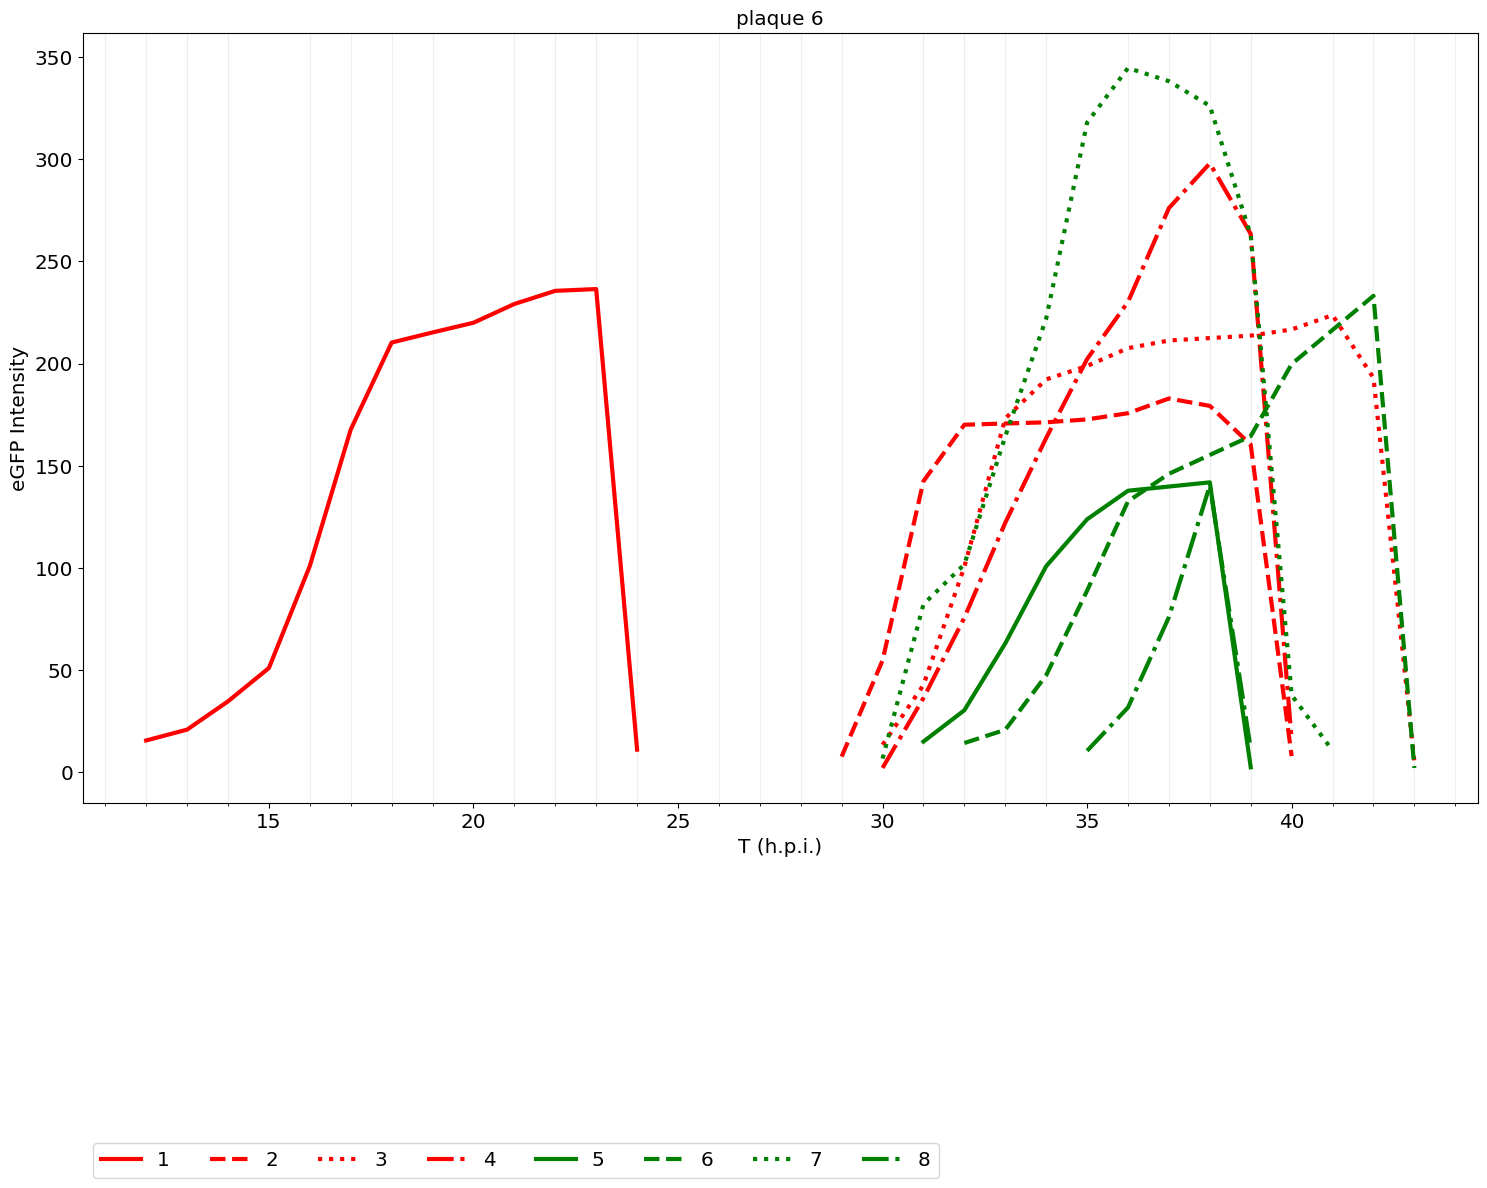

In [ ]:
file_name = 'experimental data.xlsx'
sheet_name = 'plaque 6'
df = pd.read_excel(file_name, sheet_name)
all_cells_single_plot(df)